# Developing and testing Gaussian Mixture Model (GMM) for intramuscular fat segmentation task

<IPython.core.display.Javascript object>


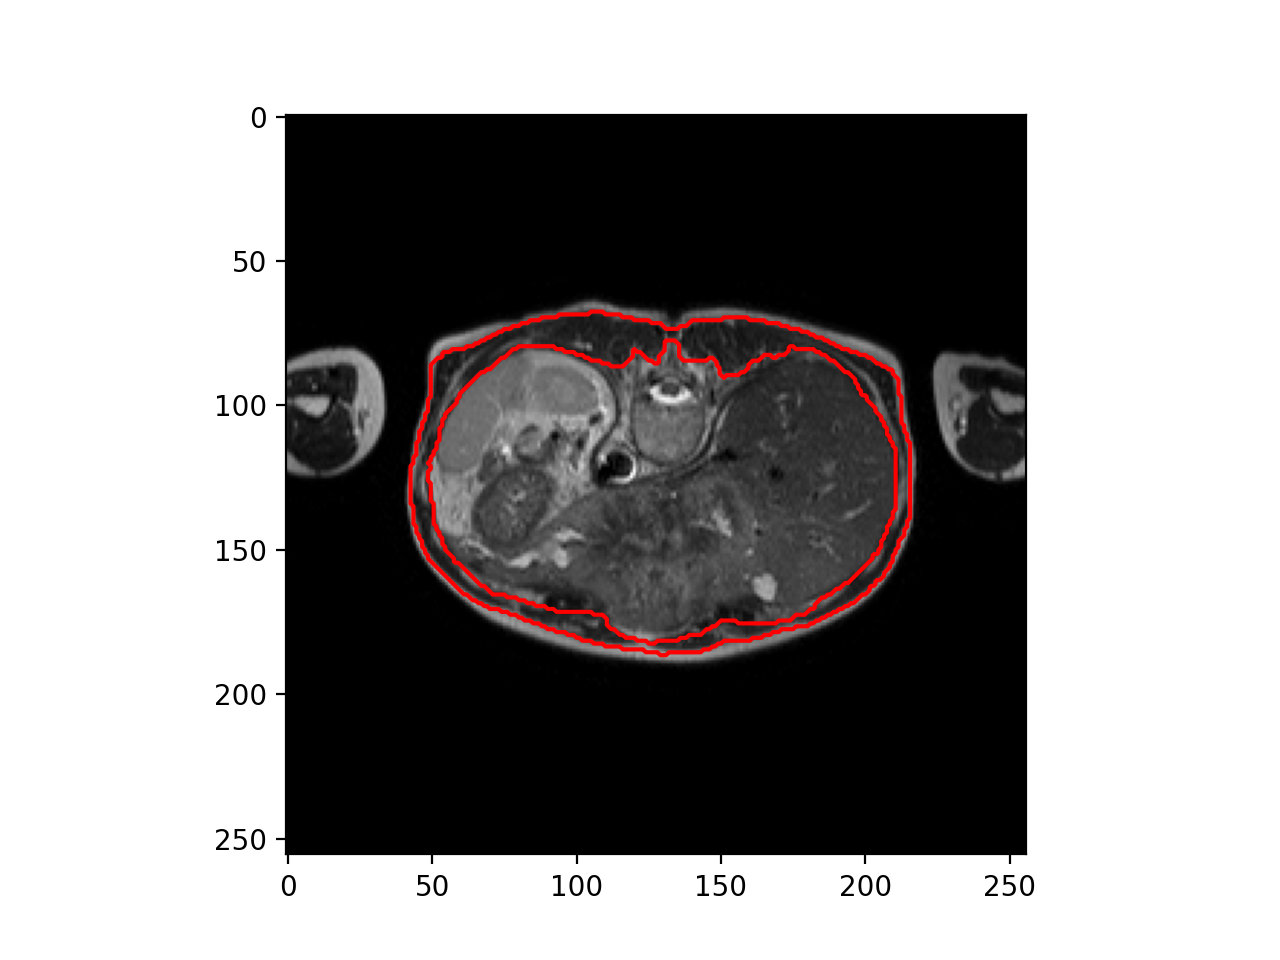

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np

# mask = sitk.ReadImage("/Users/bthomas/Downloads/data_for_Belvin/DL_tests/Seg01/outs/MR03_roi96x96x48_small/segA061_v5_T2W.nii.gz")
# im = sitk.ReadImage("/Users/bthomas/Downloads/data_for_Belvin/DL_tests/Seg01/imagesTr/A061_v5_T2W.nii.gz")
mask = sitk.ReadImage("/Users/bthomas/Downloads/data_for_Belvin/DL_tests/Seg01/labelsTr/A071_v2_T2W_seg.nii.gz")
im = sitk.ReadImage("/Users/bthomas/Downloads/data_for_Belvin/DL_tests/Seg01/imagesTr/A071_v2_T2W.nii.gz")

array_im = sitk.GetArrayFromImage(im)
array_mask = sitk.GetArrayFromImage(mask)

muscle = array_mask == 5

subcutfat = array_im[array_mask==2]
intfat = array_im[array_mask==3]
psoas = array_im[array_mask==4]


plt.imshow(array_im[15, :, :], cmap = 'gray')
plt.contour(muscle[15, :, :], levels = [0.5], colors = ['r'])
plt.show()

<IPython.core.display.Javascript object>


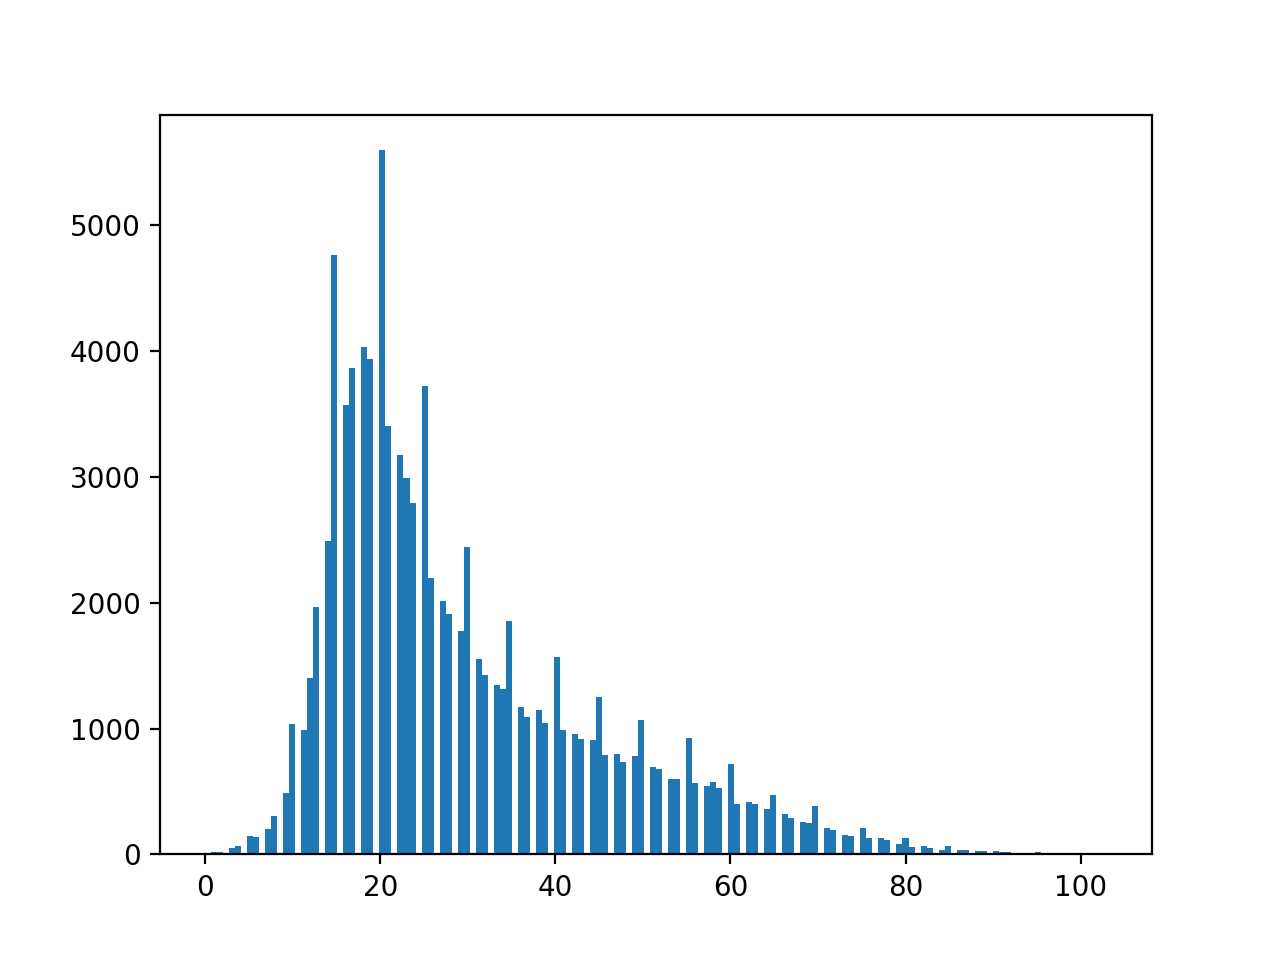

In [2]:
m = array_im[muscle]
plt.figure()
plt.hist(m, bins = 150)
plt.show()

In [4]:
# plt.figure()
# plt.hist(m + np.random.rand() - 0.5, bins = 100)
# plt.show()
from scipy import stats as st
print('Mean',np.mean(m))
print('Median',np.median(m))
print('Mode',st.mode(m))

Mean 29.731779031470456
Median 25.0
Mode ModeResult(mode=array([20], dtype=int16), count=array([5597]))


In [4]:
from sklearn.mixture import GaussianMixture as GMM

# gmm_model = GMM(n_components = 2, means_init= [[22],[63.5]])
gmm_model = GMM(n_components = 2, means_init= [[np.mean(psoas)],[np.mean(subcutfat)]])
gmm_model.fit(m[:,None])

print('Means   : \n',gmm_model.means_)
print('\nCovariances   : \n',gmm_model.covariances_)

Means   : 
 [[20.51245996]
 [45.50057022]]

Covariances   : 
 [[[ 38.20681619]]

 [[221.12703258]]]


<IPython.core.display.Javascript object>


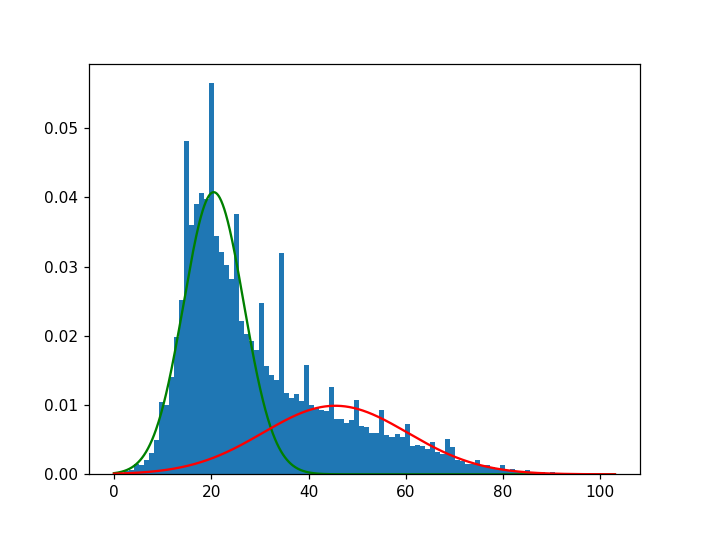

In [5]:
from scipy.stats import norm

m1 = gmm_model.means_[0]
m2 = gmm_model.means_[1]

w1 = gmm_model.weights_[0]
w2 = gmm_model.weights_[1]

v1 = gmm_model.covariances_[0, 0, 0]
v2 = gmm_model.covariances_[1, 0, 0]

plt.figure()
plt.hist(m, bins = 100, density = True)
x = np.linspace(m.min(), m.max(), 1000)
plt.plot(x, w1 * norm.pdf(x, m1, np.sqrt(v1)), "g-")
plt.plot(x, w2 * norm.pdf(x, m2, np.sqrt(v2)), "r-")
plt.show()

In [6]:
labels = gmm_model.predict(m[:, None])

In [7]:
newlabel = labels + 5

In [8]:
# im_1D = array_im.flatten()
mask_1D = array_mask.flatten()
# muscle_1D = muscle.flatten()
# muscle = im_1D[muscle_1D]
indices = np.where(mask_1D == 5)[0]

In [9]:
mask_1D[indices] = newlabel

In [10]:
newmask = mask_1D.reshape(array_im.shape)

<IPython.core.display.Javascript object>


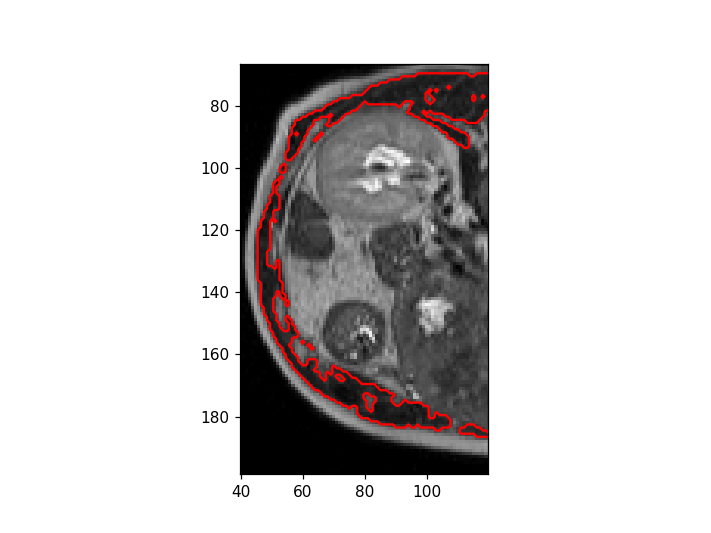

In [11]:
newmuscle = newmask == 5
fatinmuscle = newmask ==6

plt.figure()
plt.imshow(array_im[10, :, :], cmap = 'gray')
plt.contour(newmuscle[10, :, :], levels = [0.5], colors = ['r'])
# plt.contour(fatinmuscle[10, :, :], levels = [0.2], colors = ['g'])
plt.show()

<IPython.core.display.Javascript object>


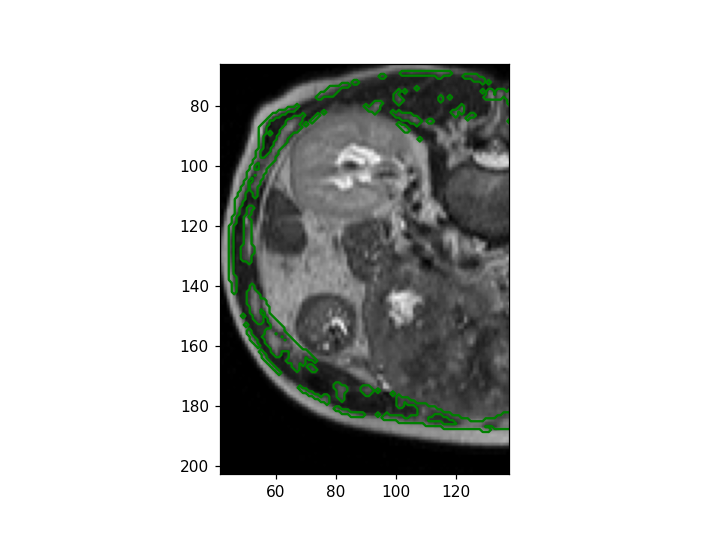

In [12]:
plt.figure()
plt.imshow(array_im[10, :, :], cmap = 'gray')
# plt.contour(newmuscle[10, :, :], levels = [0.5], colors = ['r'])
plt.contour(fatinmuscle[10, :, :], levels = [0.2], colors = ['g'])
plt.show()

In [13]:
print('means  \n',gmm_model.means_)
print('\nWeights  \n',gmm_model.weights_)

means  
 [[20.51245996]
 [45.50057022]]

Weights  
 [0.63105177 0.36894823]


In [14]:
help(GMM)

Help on class GaussianMixture in module sklearn.mixture._gaussian_mixture:

class GaussianMixture(sklearn.mixture._base.BaseMixture)
 |  GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)
 |  
 |  Gaussian Mixture.
 |  
 |  Representation of a Gaussian mixture model probability distribution.
 |  This class allows to estimate the parameters of a Gaussian mixture
 |  distribution.
 |  
 |  Read more in the :ref:`User Guide <gmm>`.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  n_components : int, default=1
 |      The number of mixture components.
 |  
 |  covariance_type : {'full', 'tied', 'diag', 'spherical'}, default='full'
 |      String describing the type of covariance parameters to use.
 |      Must be one of:
 |  
 |      - 'full': each component has 

In [17]:
newmaskimage = sitk.GetImageFromArray(newmask)
sitk.WriteImage(newmaskimage,'/Users/bthomas/Downloads/data_for_Belvin/GMMouts/A071_v2_T2W_seg_SubcutFatmeansInitialised.nii.gz')

In [16]:
# import numpy as np

# orginal_array = np.arange(15).reshape(5, 3)
# print('Original array:\n', orginal_array)
# a = orginal_array.ravel()
# print("employing ravel function on orginal array will result in : ", a)
# b = orginal_array.flatten()
# print("employing flatten function on orginal array will result in : ", b)
# print("############################################################")
# b[2] = 10000
# print('Original array:\n', orginal_array)
# print("Array b : ", b)

# a[2] = 10000
# print('Original array:\n', orginal_array)
# print("Array a : ", a)
